In [1]:
package_paths = [r"C:\Users\benja\Documents\projects\goalscorers"]
import sys
for path in package_paths:
    sys.path.append(path)
import goalscorer_package.constants as c
import goalscorer_package.data_cleaning as dc
import goalscorer_package.modelling as m
import datetime as dt
import pandas as pd
import numpy as np
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import arviz as az
print(f"Running on Az v{az.__version__}")
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
from statistics import mode
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.options.display.float_format = "{: ,.3f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_formats = ["retina"]

Running on PyMC v5.6.1
Running on Az v0.16.0


In [2]:
seasons = ["2020-2021"]
comp_ids = [9, 10, 11]
# seasons = ["2021-2022"]
# comp_ids = [9]

In [3]:
def data(seasons: list[str], comp_ids: list[int]) -> pd.DataFrame:
    seasons_leagues = dc.get_seasons_leagues_from_str(seasons, comp_ids)
    df = dc.load_seasons_leagues_files("summary", True, seasons_leagues)
    df = dc.split_positions(df)
    # df = dc.position_to_generic_position(df)
    df = dc.add_frac_90(df)
    df = dc.add_home(df)
    df = dc.add_opp_team(df)
    df = dc.drop_gk(df)
    df = dc.drop_na_npxg(df)
    df = dc.drop_na_frac_90(df)
    df = dc.add_league(df)
    df["league_10"] = np.where((df.league == 10), 1, 0)    
    return df

In [4]:
df = data(seasons, comp_ids)

In [5]:
df_model = df[["npxg", "home", "player", "opposition_team", "frac_90", "position", "league_10"]].copy()
df_model.head()

,npxg,home,player,opposition_team,frac_90,position,league_10
0,0.000,1,Aboubakar Kamara,Arsenal,0.689,FW,0
1,0.000,1,Aleksandar Mitrović,Arsenal,0.311,FW,0
2,0.000,1,Ivan Cavaleiro,Arsenal,1.000,LW,0
3,0.000,1,Neeskens Kebano,Arsenal,0.689,RW,0
4,0.000,1,Andre-Frank Zambo Anguissa,Arsenal,0.311,RW,0


In [6]:
player_codes, players = pd.factorize(df_model.loc[:, "player"], sort=True)
team_codes, teams = pd.factorize(df_model.loc[:, "opposition_team"], sort=True)

coords = {"players": players, "teams": teams}

In [7]:
df_players = df.copy()
df_players.position = df_players.position.str.split(",", expand=True)[0]
df_player_positions = df_players.groupby(["player", "position"], as_index=False)["home_team"].count().rename(columns={"home_team": "position_count"})
df_player_positions["position_count_max"] = df_player_positions.groupby("player")["position_count"].transform("max")
df_player_positions = df_player_positions[df_player_positions.position_count == df_player_positions.position_count_max].reset_index(drop=True)
df_player_positions = df_player_positions.groupby(["player"], as_index=False)["position"].first()
df_player_positions.index = df_player_positions.player
df_player_positions = df_player_positions.loc[players]

In [8]:
position_mapping = {
    "LB": (-4.07, 0.04),
    "CB": (-3.29, 1.41),
    "RB": (-4.08, 0.72),
    "WB": (-2.51, 1.1),
    "DM": (-3.33, 0.77),
    "LM": (-2.25, 0.71),
    "CM": (-3.28, 0.79),
    "RM": (-2.31, 0.98),
    "AM": (-1.63, 0.79),
    "LW": (-1.24, 0.98),
    "FW": (-1.1, 0.32),
    "RW": (-1.54, 0.79),
}

positions = list(position_mapping.keys())
conditions = [(df_player_positions.position.values == position) for position in positions]
mus = [position_mapping[position][0] for position in positions]
sigmas = [position_mapping[position][1] for position in positions]

df_player_positions["mu"] = np.select(conditions, mus)
df_player_positions["sigma"] = np.select(conditions, sigmas)

In [9]:
# Weighted Exponential
def logp(value: pt.TensorVariable, lam: pt.TensorVariable, w: pt.TensorVariable) -> pt.TensorVariable:
    log_prob = w * (np.log(lam) - lam * value)
    return log_prob

def random(lam, w, rng=None, size=None):
    return scipy.stats.expon.rvs(scale=1.0/lam, size=size)

In [10]:
with pm.Model(coords=coords) as model:
    # Priors
    λ = pm.Normal("λ", mu=0.0, sigma=0.5)
    Δ = pm.Normal("Δ", mu=df_player_positions.mu.values, sigma=df_player_positions.sigma.values, dims="players")
    β_ = pm.Normal("β_", mu=0.0, sigma=0.35, dims="teams")

    # Deterministic transform
    β = pm.Deterministic("β", β_ - β_.mean(), dims="teams")

    η = pm.Deterministic("η", pt.exp(λ * df_model["home"].values + Δ[player_codes] - β[team_codes] + 0.4*df_model.league_10.values))
    τ = pm.MutableData("τ", df_model["frac_90"].values)

    exp = pm.Deterministic("exp", 1/(η * τ))

    # Likelihood
    # x = pm.Exponential("x", lam=exp, observed=df_model["npxg"].values)
    x = pm.CustomDist(
        "x",
        exp, df_model.frac_90.values,
        logp=logp,
        random=random,
        observed=df_model.npxg.values
    )

In [11]:
with model:
    prior = pm.sample_prior_predictive(samples=1000)

Sampling: [x, Δ, β_, λ]


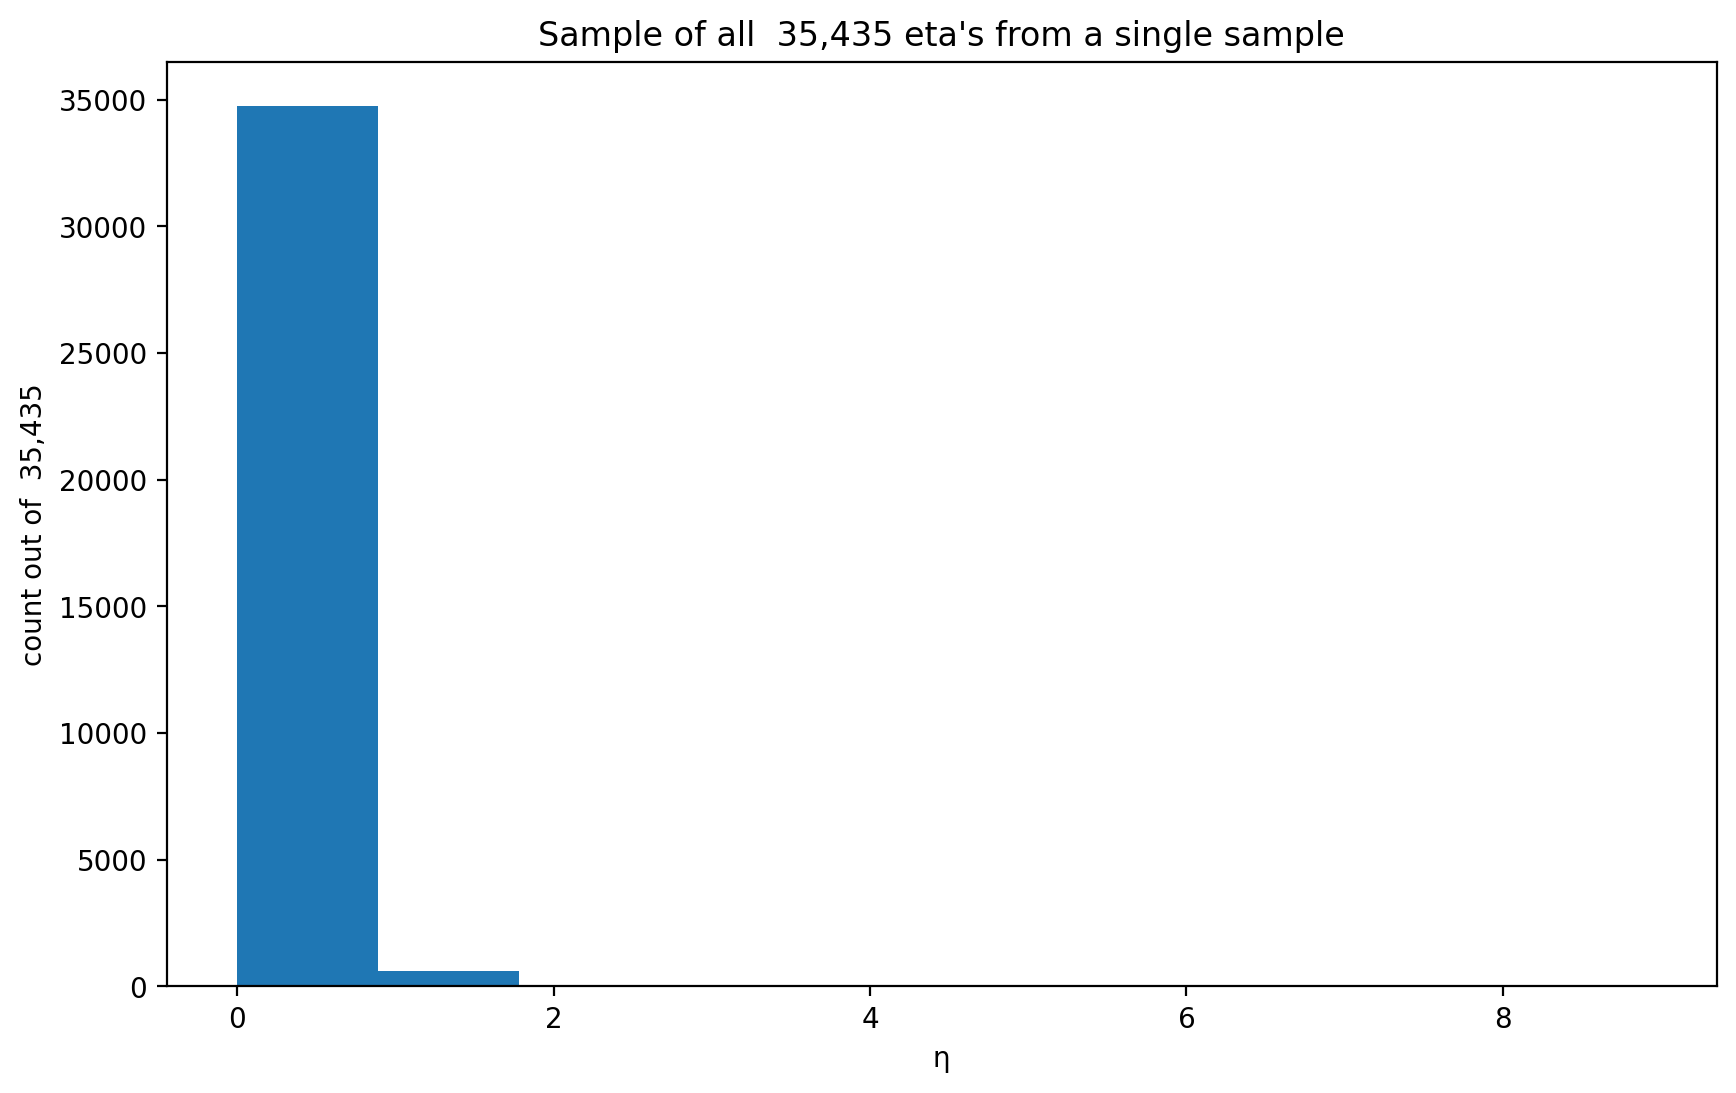

In [12]:
# sample of all eta's form a single sim

plt.hist(prior.prior.η.sel(chain=0, draw=0).data)
plt.title(f"Sample of all {len(df_model): ,} eta's from a single sample")
plt.xlabel("η")
plt.ylabel(f"count out of {len(df_model): ,}");

In [ ]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
az.summary(idata, var_names=["λ", "Δ", "β"])

In [ ]:
az.plot_trace(idata, var_names=["λ", "Δ", "β"])

In [ ]:
az.plot_energy(idata);

In [ ]:
az.plot_posterior(idata, var_names=["λ", "Δ", "β"])

In [ ]:
az.plot_forest(idata, var_names=["λ", "Δ", "β"])